## Basic Setup

In [236]:
%pip install seaborn tikzplotlib
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
import wandb
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from IPython.display import HTML
import matplotlib.pyplot as plt
import tikzplotlib

wandb.login()

model = T5ForConditionalGeneration.from_pretrained('t5-small')
model.eval()
tokenizer = T5Tokenizer.from_pretrained('t5-small', legacy=True)

def restore_model(n_docs, n_queries) -> T5ForConditionalGeneration:
    model = T5ForConditionalGeneration.from_pretrained('t5-small')
    project_path = f'tribler/retrieval-{n_docs}'
    artifact = wandb.Api().artifact(f'{project_path}/model_{n_docs}_{n_queries}:latest', type='model')
    artifact_dir = artifact.download()
    state_dict = torch.load(f'{artifact_dir}/model_{n_docs}_{n_queries}.pth', map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()
    return model

def restore_df(n_docs, n_queries) -> list[str]:
    project_path = f'tribler/retrieval-{n_docs}'
    artifact_name = f'retrieval_test_{n_docs}_{n_queries}:latest'
    artifact = wandb.Api().artifact(f"{project_path}/{artifact_name}", type='results')
    artifact_dir = artifact.download()
    table = artifact.get(f'retrieval_test_{n_docs}_{n_queries}')
    df = pd.DataFrame(data=table.data, columns=table.columns)
    return df

def get_embedding(query):
    input_ids = tokenizer(query, return_tensors="pt").input_ids
    with torch.no_grad():
        encoder_outputs = model.encoder(input_ids=input_ids)
    last_hidden_states = encoder_outputs.last_hidden_state
    return last_hidden_states.mean(dim=1)

results = []
df = restore_df(100, 20)

for docid, queries in df.groupby('test_output')['test_input'].agg(lambda x: list(set(x))).items():
    for n_queries in range(1, 21):
        query_embeddings = np.array([get_embedding(query).numpy() for query in queries[:n_queries]])
        doc_embedding = query_embeddings.mean(axis=0)
        
        results.append({
            'docid': docid,
            'n_queries': n_queries,
            'embedding': doc_embedding
        })

results_df = pd.DataFrame(results)

Note: you may need to restart the kernel to use updated packages.


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


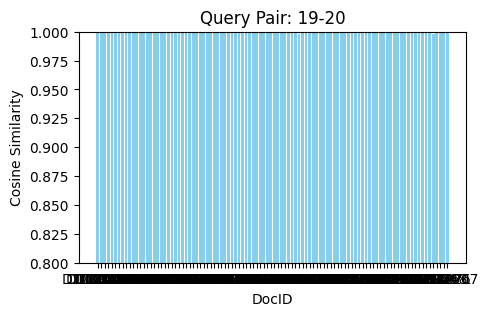

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarities for all pairs
def calculate_cosine_similarities(df):
    max_queries = df['n_queries'].max()
    cosine_similarities = []
    for n_query in range(1, max_queries):
        current_df = df[df['n_queries'] == n_query]
        next_df = df[df['n_queries'] == n_query + 1]
        for docid in df['docid'].unique():
            if docid in current_df['docid'].values and docid in next_df['docid'].values:
                current_emb = current_df[current_df['docid'] == docid]['embedding'].values[0].reshape(1, -1)
                next_emb = next_df[next_df['docid'] == docid]['embedding'].values[0].reshape(1, -1)
                sim = cosine_similarity(current_emb, next_emb)[0][0]
                cosine_similarities.append({'n_queries': f'{n_query}-{n_query + 1}', 'docid': docid, 'cosine_similarity': sim})
    return pd.DataFrame(cosine_similarities)

# Update the bar plot for each frame in the animation
def update(frame_number, similarities_df, bars, ax):
    plt.cla()  # Clear the current axes
    frame_df = similarities_df[similarities_df['n_queries'] == f'{frame_number + 1}-{frame_number + 2}']
    docids = frame_df['docid']
    similarities = frame_df['cosine_similarity']
    bars = plt.bar(docids, similarities, color='skyblue')
    ax.set_ylim(0.8, 1)  # Cosine similarity ranges from 0 to 1
    ax.set_xlabel('DocID')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title(f'Query Pair: {frame_number + 1}-{frame_number + 2}')
    return bars

# Main function to create the animation
def create_animation(results_df):
    similarities_df = calculate_cosine_similarities(results_df)
    max_queries = results_df['n_queries'].max() - 1
    fig, ax = plt.subplots(figsize=(5, 3))
    bars = plt.bar([], [])
    
    anim = FuncAnimation(fig, update, frames=range(max_queries), fargs=(similarities_df, bars, ax), blit=False, repeat=False)
    return anim

anim = create_animation(results_df)
HTML(anim.to_html5_video())

## Plotting

In [222]:
results_df

,docid,n_queries,embedding,x,y
0,D1019754,1,"[[0.04735663, 0.07856851, 0.019822253, 0.01812...",-25.308147,36.118240
1,D1019754,2,"[[0.014458258, 0.099953726, -0.01877959, -0.00...",-24.349100,36.454536
2,D1019754,3,"[[0.030094141, 0.08157425, 0.0030478004, 0.004...",-24.515684,36.244781
3,D1019754,4,"[[0.0096719125, 0.08151134, 0.013228366, -0.01...",-24.394045,36.112400
4,D1019754,5,"[[-0.0122656785, 0.05764236, 0.013965383, -0.0...",-24.302263,36.023239
...,...,...,...,...,...
1995,D972207,16,"[[0.026397452, 0.12346927, -0.03658338, -0.017...",16.625704,-10.510313
1996,D972207,17,"[[0.02638568, 0.12731713, -0.038446635, -0.025...",16.615837,-10.500719
1997,D972207,18,"[[0.029902421, 0.12982836, -0.039549578, -0.02...",16.631243,-10.480949
1998,D972207,19,"[[0.028011823, 0.13131629, -0.034462333, -0.02...",16.498121,-10.419592


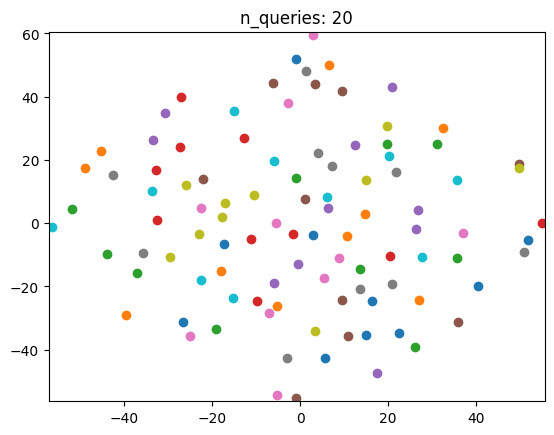

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

def preprocess_and_reduce_dimensions(df, n_components=2):
    # Flatten all embeddings and prepare for dimensionality reduction
    all_embeddings = np.array([emb.flatten() for emb in df['embedding'].tolist()])
    reducer = TSNE(n_components=n_components, learning_rate='auto', init='random', random_state=42) # or PCA(n_components=n_components)
    
    # Apply dimensionality reduction
    reduced_embeddings = reducer.fit_transform(all_embeddings)
    
    # Assign reduced dimensions back to DataFrame
    df[['x', 'y']] = reduced_embeddings
    return df

# Update the plotting function for fixed scales and colors
def update(frame_number, df, ax, xlim, ylim, color_dict):
    plt.cla()  # Clear the current axes
    frame_df = df[df['n_queries'] == frame_number + 1]
    for docid, group_df in frame_df.groupby('docid'):
        ax.scatter(group_df['x'], group_df['y'], color=color_dict[docid], label=docid)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(f'n_queries: {frame_number + 1}')

def create_animation(results_df):
    # Color mapping
    unique_docids = results_df['docid'].unique()
    colors = list(mcolors.TABLEAU_COLORS.keys())  # Extend or modify as needed
    color_dict = {docid: colors[i % len(colors)] for i, docid in enumerate(unique_docids)}
    
    # Preprocess and reduce dimensions for the entire dataset
    all_reduced_df = preprocess_and_reduce_dimensions(results_df.copy())
    
    # Determine fixed xlim and ylim based on all data
    xlim = (all_reduced_df['x'].min(), all_reduced_df['x'].max())
    ylim = (all_reduced_df['y'].min(), all_reduced_df['y'].max())
    
    fig, ax = plt.subplots()
    
    max_queries = results_df['n_queries'].max()
    anim = FuncAnimation(fig, update, frames=range(max_queries), fargs=(all_reduced_df, ax, xlim, ylim, color_dict), repeat=False)
    
    # Save the animation
    return anim

def get_results(size=100):
    selected_docids = results_df['docid'].unique()[:size]
    reduced_results_df = results_df[results_df['docid'].isin(selected_docids)]
    return reduced_results_df

anim = create_animation(get_results())
HTML(anim.to_html5_video())

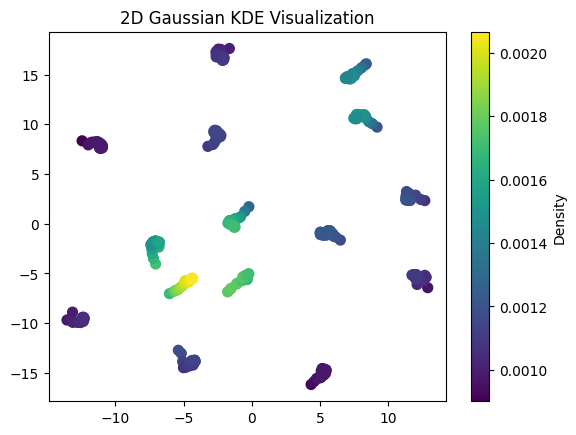

In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde

def preprocess_and_reduce_dimensions(df, n_components=2):
    # Assuming df['embedding'] is a list of numpy arrays or similar
    all_embeddings = np.array([emb.flatten() for emb in df['embedding'].tolist()])
    reducer = TSNE(n_components=n_components, learning_rate='auto', init='random', random_state=42)
    reduced_embeddings = reducer.fit_transform(all_embeddings)
    df[['x', 'y']] = reduced_embeddings
    return df

def plot_with_gaussian_fit(df):
    df = preprocess_and_reduce_dimensions(df.copy())
    
    # Calculate KDE for the density
    x, y = df['x'], df['y']
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    # Correcting color usage by explicitly using a colormap
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=z, s=50, cmap='viridis')
    fig.colorbar(scatter, ax=ax, label='Density')
    ax.set_title('2D Gaussian KDE Visualization')
    
    return fig, ax

# Make sure your dataframe `results_df` is properly initialized with an 'embedding' column
# results_df = ...

# To plot
def get_results(size=100):
    selected_docids = results_df['docid'].unique()[:size]
    reduced_results_df = results_df[results_df['docid'].isin(selected_docids)]
    # print(selected_docids, reduced_results_df)
    return reduced_results_df

fig, ax = plot_with_gaussian_fit(get_results(size=15))
plt.show()


In [278]:
results_df

,docid,n_queries,embedding
0,D1019754,1,"[[0.04735663, 0.07856851, 0.019822253, 0.01812..."
1,D1019754,2,"[[0.014458258, 0.099953726, -0.01877959, -0.00..."
2,D1019754,3,"[[0.030094141, 0.08157425, 0.0030478004, 0.004..."
3,D1019754,4,"[[0.0096719125, 0.08151134, 0.013228366, -0.01..."
4,D1019754,5,"[[-0.0122656785, 0.05764236, 0.013965383, -0.0..."
...,...,...,...
1995,D972207,16,"[[0.026397452, 0.12346927, -0.03658338, -0.017..."
1996,D972207,17,"[[0.02638568, 0.12731713, -0.038446635, -0.025..."
1997,D972207,18,"[[0.029902421, 0.12982836, -0.039549578, -0.02..."
1998,D972207,19,"[[0.028011823, 0.13131629, -0.034462333, -0.02..."


In [290]:
preprocess_and_reduce_dimensions(get_results(100))

,docid,n_queries,embedding,x,y
0,D1019754,1,"[[0.04735663, 0.07856851, 0.019822253, 0.01812...",23.345474,-35.252113
1,D1019754,2,"[[0.014458258, 0.099953726, -0.01877959, -0.00...",23.765398,-34.354366
2,D1019754,3,"[[0.030094141, 0.08157425, 0.0030478004, 0.004...",23.531464,-34.513573
3,D1019754,4,"[[0.0096719125, 0.08151134, 0.013228366, -0.01...",23.418600,-34.353802
4,D1019754,5,"[[-0.0122656785, 0.05764236, 0.013965383, -0.0...",23.335894,-34.253551
...,...,...,...,...,...
1995,D972207,16,"[[0.026397452, 0.12346927, -0.03658338, -0.017...",-5.991887,20.052666
1996,D972207,17,"[[0.02638568, 0.12731713, -0.038446635, -0.025...",-5.987264,20.040075
1997,D972207,18,"[[0.029902421, 0.12982836, -0.039549578, -0.02...",-5.965220,20.041811
1998,D972207,19,"[[0.028011823, 0.13131629, -0.034462333, -0.02...",-5.984703,19.892672


/var/folders/fz/h_r0ypg14n9ck7sr91hf8ntm0000gn/T/ipykernel_85091/764603713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y']] = reduced_embeddings
/var/folders/fz/h_r0ypg14n9ck7sr91hf8ntm0000gn/T/ipykernel_85091/764603713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y']] = reduced_embeddings
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


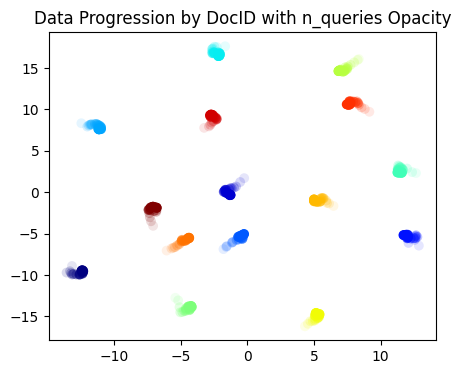

In [299]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


def plot_progression_by_docid(df, fig_size=(5, 4), dot_size=50):
    # Create the figure with specified size
    fig, ax = plt.subplots(figsize=fig_size)
    
    # Determine unique docids and sort them if needed
    unique_docids = sorted(df['docid'].unique())
    
    # Map each docid to a color
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_docids)))
    color_dict = {docid: color for docid, color in zip(unique_docids, colors)}
    
    # Loop through each docid
    for docid in unique_docids:
        doc_df = df[df['docid'] == docid]
        # Normalize n_queries for opacity mapping
        n_queries_normalized = np.interp(doc_df['n_queries'], (doc_df['n_queries'].min(), doc_df['n_queries'].max()), (0.1, 1))
        
        # Plot each point for this docid
        for (x, y, opacity) in zip(doc_df['x'], doc_df['y'], n_queries_normalized):
            ax.scatter(x, y, alpha=opacity, color=color_dict[docid], edgecolor='none', s=dot_size)

    ax.set_title('Data Progression by DocID with n_queries Opacity')
    # Turn off the legend
    ax.legend().set_visible(False)
    
    return fig, ax

# After you preprocess your DataFrame and it has 'x' and 'y' columns:
fig, ax = plot_progression_by_docid(preprocess_and_reduce_dimensions(get_results(15)))
plt.show()


## Export to TikZ/TeX

In [124]:
tikzplotlib.save(
    f'../plots/cluster_{n_queries}q_{n_docs}d_pop{min_pop}{"-" + str(max_pop) if max_pop is not None else ""}.tex',
    axis_width=r'\columnwidth', axis_height=r'6cm'
)

<Figure size 640x480 with 0 Axes>